In [1]:
%matplotlib inline

In [2]:
import numpy as np
import pandas as pd
from scipy import stats, integrate
import matplotlib.pyplot as plt

In [3]:
import seaborn as sns
import shutil
from sklearn.utils import shuffle

# Importando base de dados

<p>Base com todos os dados do sudeste</p>

In [4]:
df = pd.read_csv('../data/sudeste.csv',low_memory=False)
print (len(df))

9779168


In [5]:
df = df[df['mo'].isin([1,2,3,12])] #  somente meses do verão DEZ a MAR
print (len(df))
df.sample(3)

3206856


,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
8797841,410,VALPARAISO,382.0,-21.319138,-50.930158,A734,Valparaíso,SP,2012-01-23 09:00:00,2012-01-23,...,20.6,19.7,20.2,19.2,94.0,95.0,94.0,0.0,81.0,0.0
1935411,322,S.J.DEL REI,930.0,-21.106502,-44.250928,A514,São João del Rei,MG,2014-12-22 03:00:00,2014-12-22,...,21.8,19.6,21.6,19.4,87.0,88.0,86.0,1.4,44.0,3.8
7377319,394,CAMPOS DO JORDÃO,1663.0,-22.750231,-45.603836,A706,Campos do Jordão,SP,2016-03-24 23:00:00,2016-03-24,...,16.6,16.5,16.2,16.2,100.0,100.0,100.0,0.0,0.0,0.0


In [6]:
df = df.sort_values(['wsid', 'mdct'])
df = df.reset_index(drop=True)

In [7]:
#df = df[(df['lat'].between(-20.5,-19.0, inclusive=True)) & 
#        (df['lon'].between(-44.5,-43.0, inclusive=True))] 

In [8]:
df = df[df['wsid']==329]
print (len(df))

29112


In [9]:
df.head(4)

,wsid,wsnm,elvt,lat,lon,inme,city,prov,mdct,date,...,tmin,dewp,dmax,dmin,hmdy,hmax,hmin,wdsp,wdct,gust
816792,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 00:00:00,2006-12-01,...,20.7,20.5,20.4,20.2,99.0,99.0,98.0,1.0,121.0,2.6
816793,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 01:00:00,2006-12-01,...,20.9,20.6,20.7,20.5,98.0,99.0,98.0,1.2,146.0,2.0
816794,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 02:00:00,2006-12-01,...,20.9,20.6,20.5,20.3,98.0,98.0,98.0,0.5,309.0,2.0
816795,329,BELO HOR. (PAMPULHA),854.0,-19.883945,-43.969397,A521,Belo Horizonte,MG,2006-12-01 03:00:00,2006-12-01,...,20.7,20.5,20.6,20.3,98.0,98.0,98.0,NaN,356.0,0.9


# Pré-processamento

<h3>Dados ausentes</h3>

In [10]:
missing_values_count = (df.isnull().sum()/len(df))*100

In [11]:
missing_values_count[missing_values_count > 0.1]

prcp    86.723688
gbrd    41.872767
wdsp     5.021984
gust     1.329349
dtype: float64

<p> A variável gbbr(radiação global) apresenta massivamente números nulos e não pode ser recuperada. Vamos retirar esta variável.</p>

In [12]:
df = df.drop('gbrd',1)

<p>Para as precipitações nulas foi inputado 0.0 mm. Também para o vento e rajada de vento.</p>

In [13]:
CAN_BE_NULL = ['wdsp','prcp','gust']

In [14]:
for v in CAN_BE_NULL:
    df[v] = df[v].fillna(0.0)

In [15]:
missing_values_count = (df.isnull().sum()/len(df))*100
miss = missing_values_count[missing_values_count > 0]
miss

Series([], dtype: float64)

<p>Alguns campos estão com pouquissimos valores nulos.</p>

In [16]:
DES = ['wsid','wsnm','elvt','lat','lon','inme','city','prov','mdct','date','yr','mo','da','hr']

In [17]:
V = [x for x in df.columns if x not in DES]
#df[V].describe().T

<p><b>PRONTO! Dados recuperados!</b> Agora vamos a etapa de limpeza</p>

<h3>Limpeza dos dados</h3>

In [18]:
backup_df = df.copy

<p>Alguns campos podem ser nulos</p>

In [19]:
cols = list(df.columns)

COLS_BE_NULL = ['prcp','wdsp','gust'] + DES
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'wdct']

In [20]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,29112.0,0.380702,2.269639,0.0,0.0,0.0,0.0,78.4
stp,29112.0,908.517257,89.239876,0.0,915.8,917.4,918.9,924.2
smax,29112.0,908.700110,89.580653,0.0,916.0,917.7,919.1,924.3
smin,29112.0,908.207399,89.532850,0.0,915.5,917.2,918.6,924.2
temp,29112.0,23.124210,3.927019,0.0,20.7,22.7,25.7,33.9
tmax,29112.0,17.124471,2.524743,0.0,16.1,17.5,18.7,22.6
tmin,29112.0,23.777490,4.147014,0.0,21.1,23.4,26.6,35.1
dewp,29112.0,17.726384,2.565495,0.0,16.7,18.0,19.2,23.6
dmax,29112.0,22.487236,3.703314,0.0,20.3,22.1,24.8,32.4
dmin,29112.0,16.565873,2.555016,0.0,15.5,17.0,18.2,21.6


In [21]:
df[cols] = df[cols].replace({0.0:np.nan})

In [22]:
print (len(df))
df  = df.dropna()
print (len(df))

29112
28832


<p>Verificando os mínimos e máximos por região.</p>

In [23]:
df[V].describe().T

,count,mean,std,min,25%,50%,75%,max
prcp,28832.0,0.384399,2.280322,0.0,0.0,0.0,0.0,78.4
stp,28832.0,917.276554,2.343445,906.5,915.8,917.4,918.9,924.2
smax,28832.0,917.524889,2.322062,906.7,916.1,917.7,919.1,924.3
smin,28832.0,917.027393,2.350573,906.4,915.6,917.2,918.6,924.2
temp,28832.0,23.347035,3.219508,15.3,20.7,22.8,25.7,33.9
tmax,28832.0,17.289442,1.892367,6.6,16.1,17.5,18.7,22.6
tmin,28832.0,24.008404,3.438123,16.4,21.2,23.4,26.6,35.1
dewp,28832.0,17.898533,1.887954,6.7,16.7,18.1,19.2,23.6
dmax,28832.0,22.705619,2.981447,15.0,20.3,22.1,24.9,32.4
dmin,28832.0,16.726752,1.974954,5.3,15.6,17.0,18.2,21.6


<p>Algumas regras:</p>
<ul>
   <li>Max > Min: para temperatura, humidade, pressão e ponto de orvalho</li>
   <li>Mínima para região é possivel?</li>
   <li>Máxima para região é possivel?</li>
</ul>

<p>Vamos a temperatura máxima e mínima</p>

In [24]:
x = df[(df['tmin'] > df['tmax'])]
print ('tmin>tmax',x)
x = df[(df['hmin'] > df['hmax'])]
print ('hmin>hmax',x)
x = df[(df['smin'] > df['smax'])]
print ('smin>smax',x)
x = df[(df['dmin'] > df['dmax'])]
print ('dmin>dmax',x)

tmin>tmax         wsid                  wsnm   elvt        lat        lon  inme  \
816792   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816793   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816794   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816795   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816796   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816797   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816798   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816799   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816800   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816801   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816802   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816803   329  BELO HOR. (PAMPULHA)  854.0 -19.883945 -43.969397  A521   
816804   329  BELO HOR. (PAMPULHA)  854.0

<h4>Outliers</h4>

<p>Usando boxplot para verificar se existem outliers</p> 

In [25]:
sns.set_style("whitegrid")

<p>Pressão atmosférica</p>

In [26]:
sns.set(font_scale=2) 
def bp(var):
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    #sns.boxplot(x='prov',y=var, data=df, ax=ax)
    ax = sns.distplot(df[var])
    ax2 = ax.twinx()
    sns.boxplot(x=df[var], ax=ax2)
    ax2.set(ylim=(-.5, 10))
    ax.set_title('Com outliers: ' + var)
def bp_sem(var):
    q = df[var].quantile(0.99)
    x_filt = df[df[var] < q]
    fig, ax = plt.subplots()
    fig.set_size_inches(15, 8)
    ax = sns.distplot(x_filt[var])    
    ax.set_title('Sem outliers: ' + var)

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


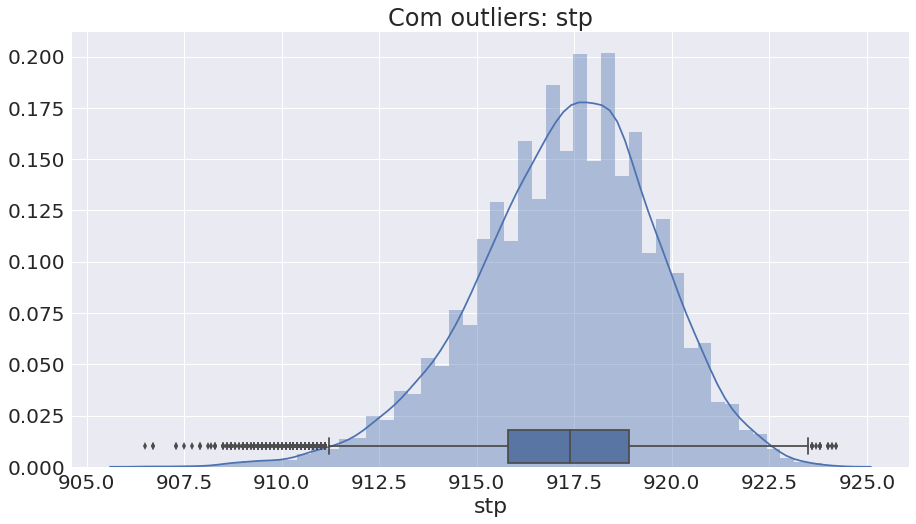

In [27]:
bp('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


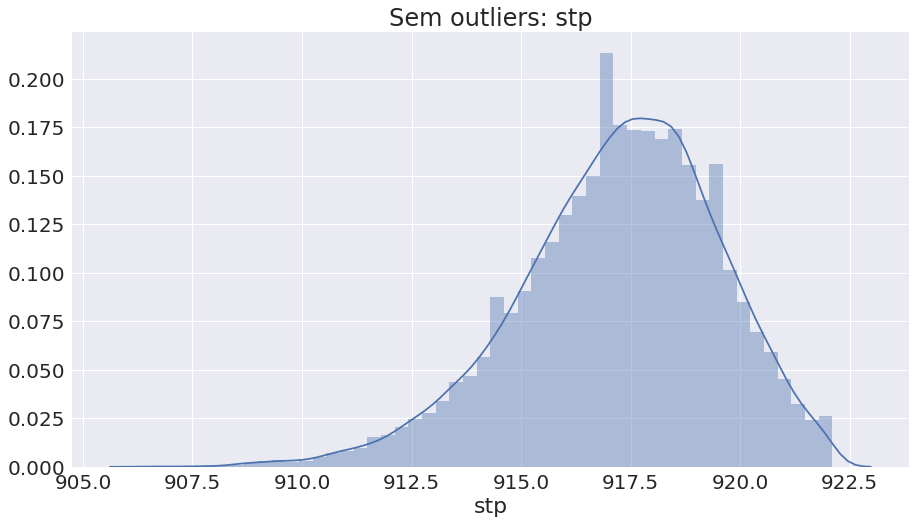

In [28]:
bp_sem('stp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


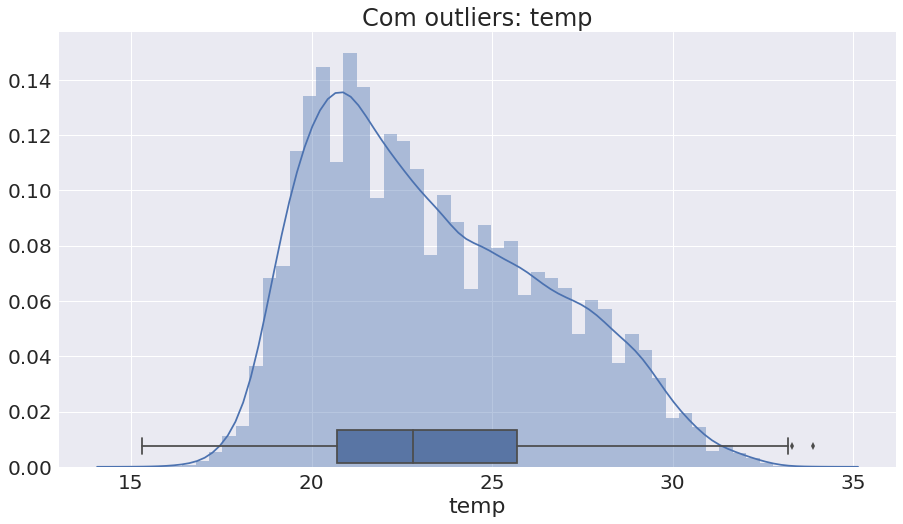

In [29]:
bp('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


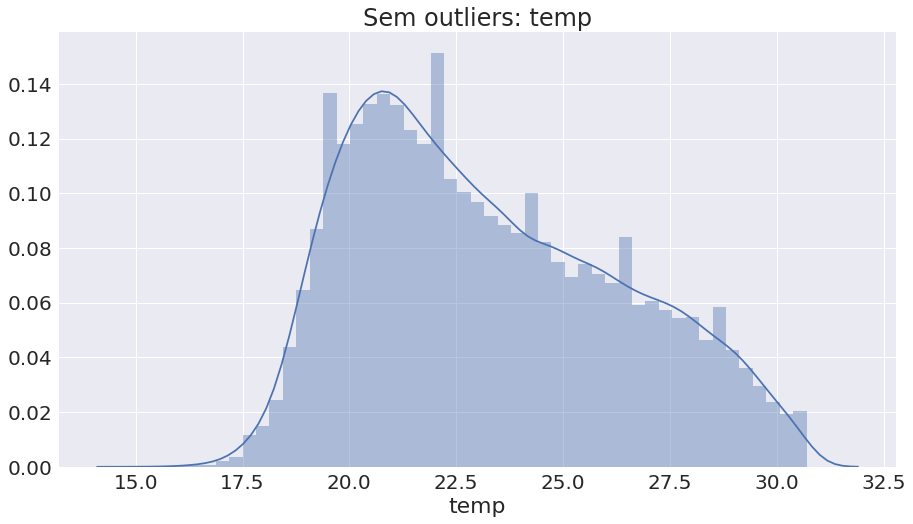

In [30]:
bp_sem('temp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


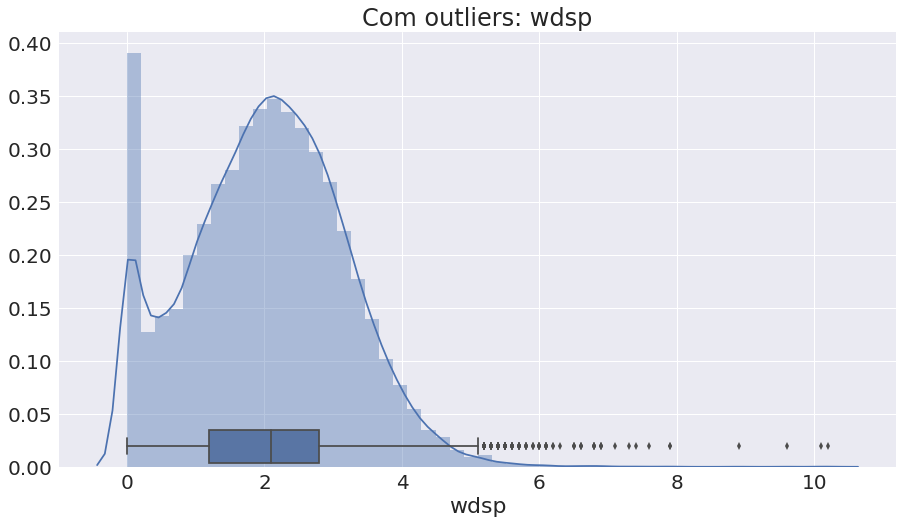

In [31]:
bp('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


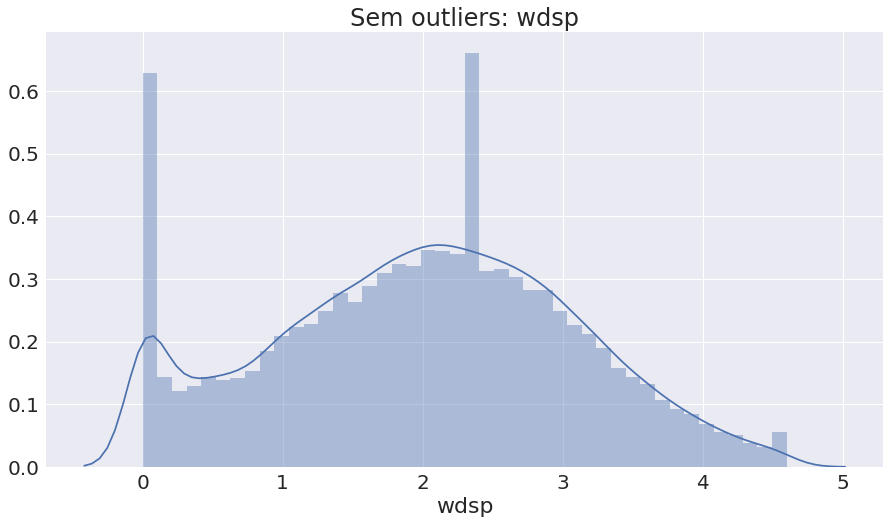

In [32]:
bp_sem('wdsp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


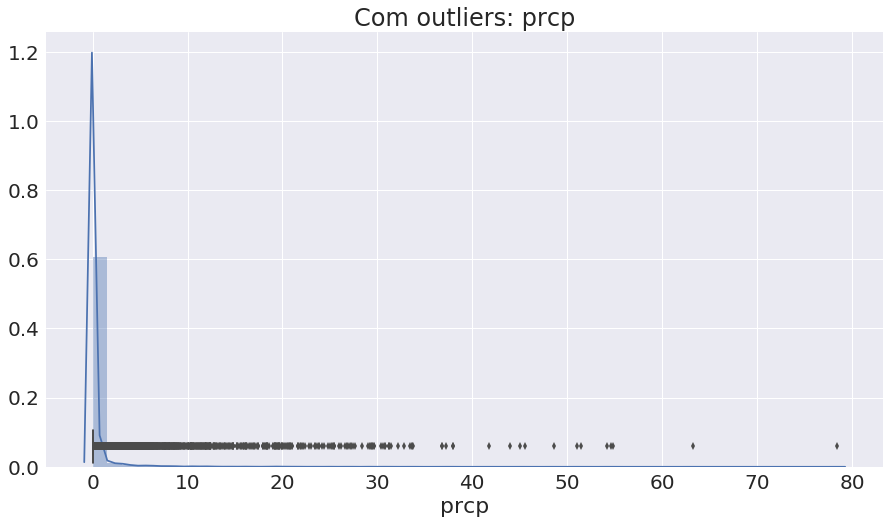

In [33]:
bp('prcp')

/home/dedeco/envs/kaggle/lib/python3.5/site-packages/matplotlib/axes/_axes.py:6448: UserWarning: The 'normed' kwarg is deprecated, and has been replaced by the 'density' kwarg.
  warnings.warn("The 'normed' kwarg is deprecated, and has been "


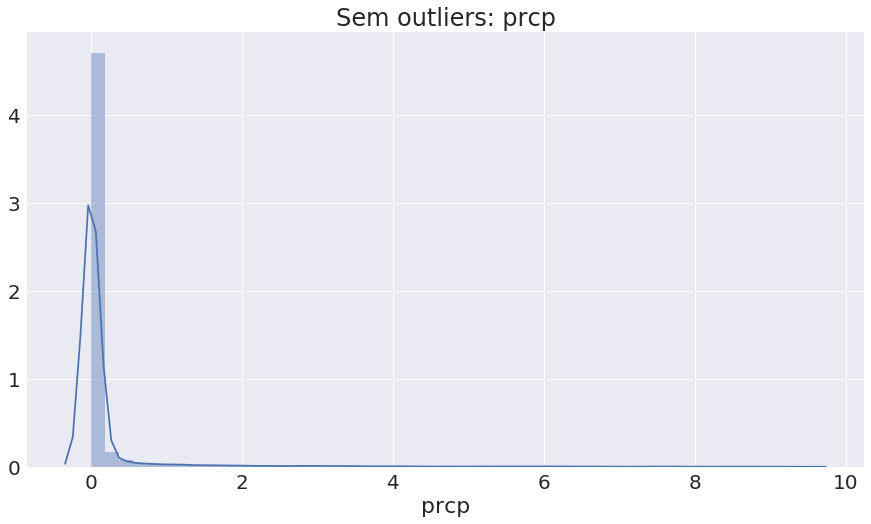

In [34]:
bp_sem('prcp')

<h3>Derivando novas variáveis (Feature engineering)</h3>

<p>Recuperando o backup do dataframe antes da limpeza dos nulos, pois preciso derivar as freatures primeiro.
Assim, após a derivá-las, irei apagar os que não pode ser nulo. Esta etapa teve que ser feita de novo, por este motivo</p> 

In [35]:
dfm = backup_df() 

In [36]:
len(dfm)

29112

In [37]:
dfm = dfm.drop('wdsp',1)
dfm = dfm.drop('wdct',1)
dfm = dfm.drop('gust',1)

<p>Conforme o Zarate orientou retirando o vento pois precisa ser modelado de forma diferente</p> 

In [38]:
CLEAN = ['wsnm','inme','city','prov','date']
REMOVE = ['yr', 'mo', 'da', 'hr']
#REMOVE = ['wsid','yr', 'mo', 'da', 'hr']
for v in CLEAN + REMOVE:
    dfm = dfm.drop(v,1)
dfm.sample(5)  

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,hmdy,hmax,hmin
832204,329,854.0,-19.883945,-43.969397,2012-01-06 04:00:00,0.0,917.8,918.2,917.8,20.0,17.6,20.3,17.6,19.9,17.3,86.0,86.0,83.0
830297,329,854.0,-19.883945,-43.969397,2011-02-16 17:00:00,0.0,917.4,918.4,917.4,29.5,15.6,29.8,17.0,27.6,15.2,43.0,49.0,43.0
836506,329,854.0,-19.883945,-43.969397,2013-03-04 10:00:00,0.0,920.1,920.1,919.6,21.9,16.5,21.9,16.6,20.6,16.1,72.0,76.0,71.0
818396,329,854.0,-19.883945,-43.969397,2007-02-05 20:00:00,3.2,913.7,914.0,913.6,26.5,20.0,27.7,21.2,26.3,19.8,68.0,71.0,64.0
837540,329,854.0,-19.883945,-43.969397,2013-12-16 12:00:00,0.0,915.0,915.1,914.9,23.3,16.7,23.7,17.4,21.8,15.6,66.0,70.0,64.0


In [39]:
ws = dfm['wsid'].groupby(dfm['wsid']).count()
ws = list(ws.keys())
print (ws)

[329]


In [40]:
def df_derived_by_shift(df,lag=0,NON_DER=[]):
    df = df.copy()
    
    if not lag:
        return df
    
    cols ={}
    for i in range(1,lag+1):
        for x in list(df.columns):
            if x not in NON_DER:
                if not x in cols:
                    cols[x] = ['{}_{}'.format(x, i)]
                else:
                    cols[x].append('{}_{}'.format(x, i))
  
    for k,v in cols.items():
        columns = v
        dfn = pd.DataFrame(data=None, columns=columns, index=df.index)    
        i = 1
        for c in columns:
            dfn[c] = df[k].shift(periods=i)
            i+=1
        df = pd.concat([df, dfn], axis=1, join_axes=[df.index])
        
    return df

In [41]:
NON_DER = ['wsid','elvt','lat', 'lon', 'yr', 'mo', 'da', 'hr']

dfr = df_derived_by_shift(dfm,24,NON_DER)

In [42]:
dfr.head(4)

var = []
cld = list(dfr.columns)
for x in cld:
    if len(x.split('_')) >= 2:
        var.append((x.split('_')[0], x.split('_')[1]))

In [43]:
cols = {}
for v,i in var:
    x = '{}_{}'.format(v, i)
    if int(i) not in cols:
        cols[int(i)] = [x]
    else:
        cols[int(i)].append(x)
#print cols

In [44]:
xxx = dfr.copy()

In [45]:
# Inicializando
xxx['prcp_acum_24'] = 99.99
xxx['prcp_plus_12'] = 99.99

In [46]:
for w in ws:
    
    size = xxx.loc[xxx['wsid'].isin([w])].iloc[:]['prcp'].count()
    
    pos_prcp = xxx.columns.get_loc('prcp')
    
    pos_acum_6 = xxx.columns.get_loc('prcp_acum_24')
    pos_plus_1 = xxx.columns.get_loc('prcp_plus_12')
    
    j=11
    
    for i in range(0,size):
        idx = xxx.loc[xxx['wsid'].isin([w])].index
        xxx.loc[xxx.loc[idx,'prcp_acum_24'].index[i],'prcp_acum_24'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+24,pos_prcp].sum()
        if i+12 < size:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12'] = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+12,pos_prcp].sum()
        else:
            xxx.loc[xxx.loc[idx,'prcp_plus_12'].index[i],'prcp_plus_12']  = xxx.loc[xxx['wsid'].isin([w])].iloc[i:i+j,pos_prcp].sum()
            j-=1

In [47]:
dfr = xxx 

In [48]:
dfr.head(12)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,smin_17,smin_18,smin_19,smin_20,smin_21,smin_22,smin_23,smin_24,prcp_acum_24,prcp_plus_12
816792,329,854.0,-19.883945,-43.969397,2006-12-01 00:00:00,0.0,915.4,915.4,914.0,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816793,329,854.0,-19.883945,-43.969397,2006-12-01 01:00:00,0.0,916.0,916.0,915.4,20.9,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.8,15.2
816794,329,854.0,-19.883945,-43.969397,2006-12-01 02:00:00,0.4,916.0,916.2,916.0,20.6,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.2,15.4
816795,329,854.0,-19.883945,-43.969397,2006-12-01 03:00:00,1.8,915.1,916.0,915.1,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,16.8,15.0
816796,329,854.0,-19.883945,-43.969397,2006-12-01 04:00:00,12.4,914.4,915.2,914.4,20.4,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,15.2,13.6
816797,329,854.0,-19.883945,-43.969397,2006-12-01 05:00:00,0.6,913.8,914.4,913.8,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.8,1.2
816798,329,854.0,-19.883945,-43.969397,2006-12-01 06:00:00,0.0,913.5,913.8,913.4,20.8,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816799,329,854.0,-19.883945,-43.969397,2006-12-01 07:00:00,0.0,913.4,913.6,913.4,20.2,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816800,329,854.0,-19.883945,-43.969397,2006-12-01 08:00:00,0.0,914.2,914.2,913.4,20.1,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.2,0.6
816801,329,854.0,-19.883945,-43.969397,2006-12-01 09:00:00,0.0,915.0,915.0,914.2,20.7,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,2.6,0.6


In [49]:
dfr.columns

Index(['wsid', 'elvt', 'lat', 'lon', 'mdct', 'prcp', 'stp', 'smax', 'smin',
       'temp',
       ...
       'smin_17', 'smin_18', 'smin_19', 'smin_20', 'smin_21', 'smin_22',
       'smin_23', 'smin_24', 'prcp_acum_24', 'prcp_plus_12'],
      dtype='object', length=356)

In [50]:
dfm = dfr

In [51]:
list(dfm.columns)

['wsid',
 'elvt',
 'lat',
 'lon',
 'mdct',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'dmax_1',
 'dmax_2',
 'dmax_3',
 'dmax_4',
 'dmax_5',
 'dmax_6',
 'dmax_7',
 'dmax_8',
 'dmax_9',
 'dmax_10',
 'dmax_11',
 'dmax_12',
 'dmax_13',
 'dmax_14',
 'dmax_15',
 'dmax_16',
 'dmax_17',
 'dmax_18',
 'dmax_19',
 'dmax_20',
 'dmax_21',
 'dmax_22',
 'dmax_23',
 'dmax_24',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'smax_7',
 'smax_8',
 'smax_9',
 'smax_10',
 'smax_11',
 'smax_12',
 'smax_13',
 'smax_14',
 'smax_15',
 'smax_16',
 'smax_17',
 'smax_18',
 'smax_19',
 'smax_20',
 'smax_21',
 'smax_22',
 'smax_23',
 'smax_24',
 'de

In [52]:
len(dfm)

29112

<h3>Preparando a base</h3>

<p>Removendo registros que não pode ser nulos e prejudicariam o treinamento</p>

In [53]:
cols = list(df.columns)
for v in ['wdsp','wdct','gust']:
    cols.remove(v)

In [54]:
COLS_BE_NULL = ['prcp'] + DES + ['temp']
for v in COLS_BE_NULL:
    if v in cols:
        cols.remove(v)
cols

['stp',
 'smax',
 'smin',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin']

In [55]:
dfm[cols] = dfm[cols].replace({0.0:np.nan}) 

In [56]:
print (len(dfm))
dfm  = dfm.dropna()
print (len(dfm))

29112
27721


In [57]:
dfm = dfm.reset_index(drop=True)

In [58]:
dfm.head(5)

,wsid,elvt,lat,lon,mdct,prcp,stp,smax,smin,temp,...,smin_17,smin_18,smin_19,smin_20,smin_21,smin_22,smin_23,smin_24,prcp_acum_24,prcp_plus_12
0,329,854.0,-19.883945,-43.969397,2006-12-02 00:00:00,0.0,918.2,918.2,917.5,18.8,...,913.4,913.4,913.8,914.4,915.1,916.0,915.4,914.0,2.0,2.0
1,329,854.0,-19.883945,-43.969397,2006-12-02 01:00:00,0.4,918.7,918.7,918.2,18.6,...,913.4,913.4,913.4,913.8,914.4,915.1,916.0,915.4,2.0,2.0
2,329,854.0,-19.883945,-43.969397,2006-12-02 02:00:00,1.0,918.7,918.8,918.7,18.4,...,914.2,913.4,913.4,913.4,913.8,914.4,915.1,916.0,1.6,1.6
3,329,854.0,-19.883945,-43.969397,2006-12-02 03:00:00,0.2,918.1,918.7,918.1,18.6,...,915.0,914.2,913.4,913.4,913.4,913.8,914.4,915.1,0.6,0.6
4,329,854.0,-19.883945,-43.969397,2006-12-02 04:00:00,0.0,917.3,918.1,917.3,18.7,...,915.7,915.0,914.2,913.4,913.4,913.4,913.8,914.4,0.4,0.4


In [59]:
dfm.to_csv('../data/derivaded.csv')

In [60]:
dfm = dfm.drop('wsid',1)
dfm = dfm.drop('mdct',1)

In [61]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'dmax_1',
 'dmax_2',
 'dmax_3',
 'dmax_4',
 'dmax_5',
 'dmax_6',
 'dmax_7',
 'dmax_8',
 'dmax_9',
 'dmax_10',
 'dmax_11',
 'dmax_12',
 'dmax_13',
 'dmax_14',
 'dmax_15',
 'dmax_16',
 'dmax_17',
 'dmax_18',
 'dmax_19',
 'dmax_20',
 'dmax_21',
 'dmax_22',
 'dmax_23',
 'dmax_24',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'smax_7',
 'smax_8',
 'smax_9',
 'smax_10',
 'smax_11',
 'smax_12',
 'smax_13',
 'smax_14',
 'smax_15',
 'smax_16',
 'smax_17',
 'smax_18',
 'smax_19',
 'smax_20',
 'smax_21',
 'smax_22',
 'smax_23',
 'smax_24',
 'dewp_1',
 'dewp_2',


In [62]:
REMOVE = ['mdct']
for i in range(1,25):
    REMOVE.append('mdct_'+str(i))
print (REMOVE)
for v in REMOVE:
    if v in list(dfm.columns):
        dfm = dfm.drop(v,1)

['mdct', 'mdct_1', 'mdct_2', 'mdct_3', 'mdct_4', 'mdct_5', 'mdct_6', 'mdct_7', 'mdct_8', 'mdct_9', 'mdct_10', 'mdct_11', 'mdct_12', 'mdct_13', 'mdct_14', 'mdct_15', 'mdct_16', 'mdct_17', 'mdct_18', 'mdct_19', 'mdct_20', 'mdct_21', 'mdct_22', 'mdct_23', 'mdct_24']


In [63]:
list(dfm.columns)

['elvt',
 'lat',
 'lon',
 'prcp',
 'stp',
 'smax',
 'smin',
 'temp',
 'tmax',
 'tmin',
 'dewp',
 'dmax',
 'dmin',
 'hmdy',
 'hmax',
 'hmin',
 'dmax_1',
 'dmax_2',
 'dmax_3',
 'dmax_4',
 'dmax_5',
 'dmax_6',
 'dmax_7',
 'dmax_8',
 'dmax_9',
 'dmax_10',
 'dmax_11',
 'dmax_12',
 'dmax_13',
 'dmax_14',
 'dmax_15',
 'dmax_16',
 'dmax_17',
 'dmax_18',
 'dmax_19',
 'dmax_20',
 'dmax_21',
 'dmax_22',
 'dmax_23',
 'dmax_24',
 'tmin_1',
 'tmin_2',
 'tmin_3',
 'tmin_4',
 'tmin_5',
 'tmin_6',
 'tmin_7',
 'tmin_8',
 'tmin_9',
 'tmin_10',
 'tmin_11',
 'tmin_12',
 'tmin_13',
 'tmin_14',
 'tmin_15',
 'tmin_16',
 'tmin_17',
 'tmin_18',
 'tmin_19',
 'tmin_20',
 'tmin_21',
 'tmin_22',
 'tmin_23',
 'tmin_24',
 'smax_1',
 'smax_2',
 'smax_3',
 'smax_4',
 'smax_5',
 'smax_6',
 'smax_7',
 'smax_8',
 'smax_9',
 'smax_10',
 'smax_11',
 'smax_12',
 'smax_13',
 'smax_14',
 'smax_15',
 'smax_16',
 'smax_17',
 'smax_18',
 'smax_19',
 'smax_20',
 'smax_21',
 'smax_22',
 'smax_23',
 'smax_24',
 'dewp_1',
 'dewp_2',


In [64]:
#como esta rede é especifica para a BH, vamos remover elvt, lat, lon
REMOVE = ['elvt','lat', 'lon']
for v in REMOVE:
    dfm = dfm.drop(v,1)

In [65]:
#dfm = dfm.drop('wsid',1)
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,smin_17,smin_18,smin_19,smin_20,smin_21,smin_22,smin_23,smin_24,prcp_acum_24,prcp_plus_12
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,913.4,913.4,913.8,914.4,915.1,916.0,915.4,914.0,2.0,2.0
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,913.4,913.4,913.4,913.8,914.4,915.1,916.0,915.4,2.0,2.0
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,914.2,913.4,913.4,913.4,913.8,914.4,915.1,916.0,1.6,1.6
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,915.0,914.2,913.4,913.4,913.4,913.8,914.4,915.1,0.6,0.6
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,915.7,915.0,914.2,913.4,913.4,913.4,913.8,914.4,0.4,0.4
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,916.2,915.7,915.0,914.2,913.4,913.4,913.4,913.8,0.4,0.4
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,916.7,916.2,915.7,915.0,914.2,913.4,913.4,913.4,0.4,0.4
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,916.9,916.7,916.2,915.7,915.0,914.2,913.4,913.4,0.4,0.4
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,916.9,916.9,916.7,916.2,915.7,915.0,914.2,913.4,0.4,0.4
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,916.4,916.9,916.9,916.7,916.2,915.7,915.0,914.2,0.0,0.0


In [66]:
#dfm.loc[28807,'prcp_plus_1'] = 0.0
#x = dfm[dfm['prcp_plus_1']==99.99]
#x

In [67]:
dfm.to_csv('../data/derivaded_2.csv')

In [68]:
def f(x):
    if x['prcp_acum_24'] == 0.0: 
        return 0
    elif x['prcp_acum_24'] <= 49.99:       
        return 1
    else:
        return 2

In [69]:
dfm['rain'] = dfm.apply(f,axis=1) 

In [70]:
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,smin_18,smin_19,smin_20,smin_21,smin_22,smin_23,smin_24,prcp_acum_24,prcp_plus_12,rain
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,913.4,913.8,914.4,915.1,916.0,915.4,914.0,2.0,2.0,1
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,913.4,913.4,913.8,914.4,915.1,916.0,915.4,2.0,2.0,1
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,913.4,913.4,913.4,913.8,914.4,915.1,916.0,1.6,1.6,1
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,914.2,913.4,913.4,913.4,913.8,914.4,915.1,0.6,0.6,1
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,915.0,914.2,913.4,913.4,913.4,913.8,914.4,0.4,0.4,1
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,915.7,915.0,914.2,913.4,913.4,913.4,913.8,0.4,0.4,1
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,916.2,915.7,915.0,914.2,913.4,913.4,913.4,0.4,0.4,1
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,916.7,916.2,915.7,915.0,914.2,913.4,913.4,0.4,0.4,1
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,916.9,916.7,916.2,915.7,915.0,914.2,913.4,0.4,0.4,1
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,916.9,916.9,916.7,916.2,915.7,915.0,914.2,0.0,0.0,0


In [71]:
bkp = dfm.copy()
dfm = dfm.drop(['prcp_plus_12'],1)
dfm = dfm.drop(['prcp_acum_24'],1)

In [72]:
dfm

,prcp,stp,smax,smin,temp,tmax,tmin,dewp,dmax,dmin,...,smin_16,smin_17,smin_18,smin_19,smin_20,smin_21,smin_22,smin_23,smin_24,rain
0,0.0,918.2,918.2,917.5,18.8,17.1,20.2,17.1,18.8,16.2,...,913.4,913.4,913.4,913.8,914.4,915.1,916.0,915.4,914.0,1
1,0.4,918.7,918.7,918.2,18.6,17.2,18.9,17.2,18.6,17.1,...,914.2,913.4,913.4,913.4,913.8,914.4,915.1,916.0,915.4,1
2,1.0,918.7,918.8,918.7,18.4,17.3,18.6,17.4,18.3,17.2,...,915.0,914.2,913.4,913.4,913.4,913.8,914.4,915.1,916.0,1
3,0.2,918.1,918.7,918.1,18.6,17.3,18.8,17.4,18.4,17.2,...,915.7,915.0,914.2,913.4,913.4,913.4,913.8,914.4,915.1,1
4,0.0,917.3,918.1,917.3,18.7,17.1,18.8,17.3,18.5,17.0,...,916.2,915.7,915.0,914.2,913.4,913.4,913.4,913.8,914.4,1
5,0.0,916.6,917.3,916.6,18.6,16.8,18.8,17.1,18.5,16.8,...,916.7,916.2,915.7,915.0,914.2,913.4,913.4,913.4,913.8,1
6,0.0,916.4,916.6,916.3,18.3,16.5,18.8,16.8,18.3,16.4,...,916.9,916.7,916.2,915.7,915.0,914.2,913.4,913.4,913.4,1
7,0.0,916.5,916.5,916.4,18.3,16.3,18.4,16.6,18.2,16.3,...,916.9,916.9,916.7,916.2,915.7,915.0,914.2,913.4,913.4,1
8,0.4,917.2,917.2,916.5,18.0,16.4,18.5,16.4,17.9,16.2,...,916.4,916.9,916.9,916.7,916.2,915.7,915.0,914.2,913.4,1
9,0.0,918.0,918.0,917.2,18.4,15.9,18.5,16.4,17.9,15.8,...,915.7,916.4,916.9,916.9,916.7,916.2,915.7,915.0,914.2,0


<h2>Mineiração dos dados</h2>

<h3>Rede neural</h3>

In [73]:
import tensorflow as tf  
from sklearn.metrics import explained_variance_score, mean_absolute_error,  median_absolute_error
from sklearn.model_selection import train_test_split 

In [74]:
target = 'rain'

In [75]:
X = dfm[[col for col in dfm.columns]]
y = dfm[target]

<p>Separando o conjunto de treinamento e validação (metade dos 10% separados para validação)</p>

In [76]:
X_train, X_tmp, y_train, y_tmp = train_test_split(X, y, test_size=0.1, random_state=12) 
print (len(X_train))
print (len(X_tmp))

24948
2773


<p>Separando o conjunto de testes</p>

In [77]:
X_test, X_val, y_test, y_val = train_test_split(X_tmp, y_tmp, test_size=0.5)

In [78]:
X_train.shape, X_test.shape, X_val.shape  
print("Training instances   {}, Training features   {}".format(X_train.shape[0], X_train.shape[1]))  
print("Validation instances {}, Validation features {}".format(X_val.shape[0], X_val.shape[1]))  
print("Testing instances    {}, Testing features    {}".format(X_test.shape[0], X_test.shape[1]))  

Training instances   24948, Training features   326
Validation instances 1387, Validation features 326
Testing instances    1386, Testing features    326


In [79]:
# Zarate instructions
st_units = (X_train.shape[1] * 2) + 1
sd_units = 3
#activation_fn = tf.sigmoid
batch_size = 500
up = int(len(X_train)/batch_size)

In [80]:
up

49

In [81]:
Z = X.copy()
Z.pop(target)
feature_cols = [tf.feature_column.numeric_column(col) for col in Z.columns] 

In [82]:
classifier = tf.estimator.DNNClassifier(
        feature_columns=feature_cols
        ,hidden_units=[st_units,sd_units]                                      
        ,n_classes = 3
        ,model_dir='/data/tmp/tf_model_10')

INFO:tensorflow:Using default config.
INFO:tensorflow:Using config: {'_service': None, '_save_checkpoints_steps': None, '_keep_checkpoint_every_n_hours': 10000, '_cluster_spec': <tensorflow.python.training.server_lib.ClusterSpec object at 0x7fdfce70ed68>, '_task_id': 0, '_num_ps_replicas': 0, '_is_chief': True, '_log_step_count_steps': 100, '_keep_checkpoint_max': 5, '_num_worker_replicas': 1, '_evaluation_master': '', '_model_dir': '/data/tmp/tf_model_10', '_tf_random_seed': None, '_save_summary_steps': 100, '_save_checkpoints_secs': 600, '_master': '', '_session_config': None, '_task_type': 'worker', '_global_id_in_cluster': 0}


In [83]:
from imblearn.under_sampling import RandomUnderSampler
under = RandomUnderSampler(return_indices=True)

In [84]:
def train_input_fn(features, labels, batch_size):
    """An input function for training"""

    dataset = tf.data.Dataset.from_tensor_slices((dict(features), labels))
    dataset = dataset.shuffle(10).repeat().batch(batch_size)
    return dataset

In [85]:
def eval_input_fn(features, labels, batch_size):
    """An input function for evaluation or prediction"""
    features=dict(features)
    if labels is None:
        inputs = features
    else:
        inputs = (features, labels)

    dataset = tf.data.Dataset.from_tensor_slices(inputs)
    
    assert batch_size is not None, "batch_size must not be None"
    dataset = dataset.batch(batch_size)

    return dataset

In [86]:
print (X_train.shape)
print (len(feature_cols))

(24948, 326)
325


In [87]:
print (X_val.shape)

(1387, 326)


In [88]:
#X_val = X_val.drop(['rain'],1)
#X_train = X_train.drop(['rain'],1)

In [89]:
print (X_train.shape)

(24948, 326)


In [90]:
evaluations = []  
train_steps = 500

for i in range(100):  
    
    print ('treinando agora...')
    
    #X_resampled, y_resampled, idx_resampled = under.fit_sample(X_train, y_train)
    X_resampled = X_train
    y_resampled = y_train
    
    classifier.train(
        input_fn=lambda:train_input_fn(X_resampled, y_resampled,
                                       batch_size),
                    steps=train_steps)
    
    eval_result = classifier.evaluate(
            input_fn=lambda:eval_input_fn(X_val, y_val,batch_size)
        )
    
    evaluations.append(eval_result)


treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 1 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 1, loss = 146346.62
INFO:tensorflow:global_step/sec: 8.38712
INFO:tensorflow:step = 101, loss = 461.1642 (11.925 sec)
INFO:tensorflow:global_step/sec: 9.13861
INFO:tensorflow:step = 201, loss = 442.56192 (10.942 sec)
INFO:tensorflow:global_step/sec: 9.07936
INFO:tensorflow:step = 301, loss = 441.1718 (11.013 sec)
INFO:tensorflow:global_step/sec: 9.19095
INFO:tensorflow:step = 401, loss = 439.14493 (10.882 sec)
INFO:tensorflow:Saving checkpoints for 500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 432.91693.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting

INFO:tensorflow:step = 2801, loss = 439.3759 (10.749 sec)
INFO:tensorflow:global_step/sec: 8.81843
INFO:tensorflow:step = 2901, loss = 437.30875 (11.339 sec)
INFO:tensorflow:Saving checkpoints for 3000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.36032.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-00:08:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-3000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-00:08:25
INFO:tensorflow:Saving dict for global step 3000: accuracy = 0.5212689, average_loss = 0.8413923, global_step = 3000, loss = 389.0037
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorfl

INFO:tensorflow:Finished evaluation at 2018-04-15-00:15:05
INFO:tensorflow:Saving dict for global step 5500: accuracy = 0.5212689, average_loss = 0.8413778, global_step = 5500, loss = 388.99698
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-5500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 5501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 5501, loss = 426.6844
INFO:tensorflow:global_step/sec: 8.678
INFO:tensorflow:step = 5601, loss = 437.96988 (11.525 sec)
INFO:tensorflow:global_step/sec: 9.40742
INFO:tensorflow:step = 5701, loss = 431.09805 (10.630 sec)
INFO:tensorflow:global_step/sec: 9.48617
INFO:tensorflow:step = 5801, loss = 442.11758 (10.542 sec)
INFO:tensorflow:global_step/sec: 9.43666
INF

INFO:tensorflow:step = 8001, loss = 429.0151
INFO:tensorflow:global_step/sec: 8.5734
INFO:tensorflow:step = 8101, loss = 437.9676 (11.665 sec)
INFO:tensorflow:global_step/sec: 9.41975
INFO:tensorflow:step = 8201, loss = 430.71408 (10.616 sec)
INFO:tensorflow:global_step/sec: 9.4173
INFO:tensorflow:step = 8301, loss = 434.86868 (10.619 sec)
INFO:tensorflow:global_step/sec: 9.26096
INFO:tensorflow:step = 8401, loss = 439.2781 (10.799 sec)
INFO:tensorflow:Saving checkpoints for 8500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.0275.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-00:22:58
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-8500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-00:22:59
INFO:tensorflow:Saving dict for global

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-00:29:36
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-00:29:37
INFO:tensorflow:Saving dict for global step 11000: accuracy = 0.5212689, average_loss = 0.84137636, global_step = 11000, loss = 388.99634
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-11000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 11001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 11001, loss = 429.0152
INFO:tensorflow:global_step/sec: 8.94

INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-13500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 13501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 13501, loss = 429.1424
INFO:tensorflow:global_step/sec: 9.059
INFO:tensorflow:step = 13601, loss = 438.22015 (11.042 sec)
INFO:tensorflow:global_step/sec: 9.78217
INFO:tensorflow:step = 13701, loss = 431.349 (10.223 sec)
INFO:tensorflow:global_step/sec: 9.88256
INFO:tensorflow:step = 13801, loss = 439.6579 (10.118 sec)
INFO:tensorflow:global_step/sec: 10.0698
INFO:tensorflow:step = 13901, loss = 437.45346 (9.931 sec)
INFO:tensorflow:Saving checkpoints for 14000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 430.9709.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done ca

INFO:tensorflow:step = 16201, loss = 431.2195 (10.193 sec)
INFO:tensorflow:global_step/sec: 9.60208
INFO:tensorflow:step = 16301, loss = 439.40323 (10.415 sec)
INFO:tensorflow:global_step/sec: 9.9483
INFO:tensorflow:step = 16401, loss = 437.32626 (10.052 sec)
INFO:tensorflow:Saving checkpoints for 16500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.48148.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-00:43:45
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-16500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-00:43:47
INFO:tensorflow:Saving dict for global step 16500: accuracy = 0.5212689, average_loss = 0.8413783, global_step = 16500, loss = 388.99722
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calli

INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-00:50:11
INFO:tensorflow:Saving dict for global step 19000: accuracy = 0.5212689, average_loss = 0.84137803, global_step = 19000, loss = 388.9971
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-19000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 19001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 19001, loss = 428.88712
INFO:tensorflow:global_step/sec: 9.06095
INFO:tensorflow:step = 19101, loss = 437.83438 (11.039 sec)
INFO:tensorflow:global_step/sec: 10.1262
INFO:tensorflow:step = 19201, 

INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 21501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 21501, loss = 429.13962
INFO:tensorflow:global_step/sec: 8.63847
INFO:tensorflow:step = 21601, loss = 437.96164 (11.577 sec)
INFO:tensorflow:global_step/sec: 9.28796
INFO:tensorflow:step = 21701, loss = 430.7117 (10.767 sec)
INFO:tensorflow:global_step/sec: 9.60418
INFO:tensorflow:step = 21801, loss = 437.4525 (10.411 sec)
INFO:tensorflow:global_step/sec: 9.41129
INFO:tensorflow:step = 21901, loss = 439.65762 (10.626 sec)
INFO:tensorflow:Saving checkpoints for 22000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.14844.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-00:57:56
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-22000
IN

INFO:tensorflow:step = 24401, loss = 435.12103 (10.075 sec)
INFO:tensorflow:Saving checkpoints for 24500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.35083.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:04:17
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-24500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:04:18
INFO:tensorflow:Saving dict for global step 24500: accuracy = 0.5212689, average_loss = 0.8413797, global_step = 24500, loss = 388.9979
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-24500
INFO:tensorflow:Running lo

INFO:tensorflow:Saving dict for global step 27000: accuracy = 0.5212689, average_loss = 0.84137934, global_step = 27000, loss = 388.9977
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-27000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 27001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 27001, loss = 426.68106
INFO:tensorflow:global_step/sec: 8.66109
INFO:tensorflow:step = 27101, loss = 438.0863 (11.547 sec)
INFO:tensorflow:global_step/sec: 9.20614
INFO:tensorflow:step = 27201, loss = 431.09134 (10.863 sec)
INFO:tensorflow:global_step/sec: 9.54031
INFO:tensorflow:step = 27301, loss = 439.6566 (10.482 sec)
INFO:tensorflow:global_step/sec: 9.38614
INFO:tensorflow:step = 27401, loss = 439.27695 (10.65

INFO:tensorflow:step = 29501, loss = 429.0121
INFO:tensorflow:global_step/sec: 8.87294
INFO:tensorflow:step = 29601, loss = 437.8335 (11.271 sec)
INFO:tensorflow:global_step/sec: 10.0532
INFO:tensorflow:step = 29701, loss = 431.09027 (9.947 sec)
INFO:tensorflow:global_step/sec: 9.72303
INFO:tensorflow:step = 29801, loss = 437.19852 (10.286 sec)
INFO:tensorflow:global_step/sec: 10.0263
INFO:tensorflow:step = 29901, loss = 437.57883 (9.972 sec)
INFO:tensorflow:Saving checkpoints for 30000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.01923.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:18:23
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-30000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:18:24
INFO:tensorflow:Saving dict f

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:24:47
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-32500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:24:49
INFO:tensorflow:Saving dict for global step 32500: accuracy = 0.5212689, average_loss = 0.84137917, global_step = 32500, loss = 388.99765
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-32500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 32501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 32501, loss = 429.26514
IN

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-35000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 35001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 35001, loss = 426.68124
INFO:tensorflow:global_step/sec: 9.08399
INFO:tensorflow:step = 35101, loss = 438.21338 (11.012 sec)
INFO:tensorflow:global_step/sec: 9.93643
INFO:tensorflow:step = 35201, loss = 430.71042 (10.062 sec)
INFO:tensorflow:global_step/sec: 9.65716
INFO:tensorflow:step = 35301, loss = 437.1986 (10.355 sec)
INFO:tensorflow:global_step/sec: 9.88573
INFO:tensorflow:step = 35401, loss = 437.45187 (10.116 sec)
INFO:tensorflow:Saving checkpoints for 35500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.1446.
INFO:tensorflow:C

INFO:tensorflow:global_step/sec: 9.76887
INFO:tensorflow:step = 37701, loss = 433.29456 (10.236 sec)
INFO:tensorflow:global_step/sec: 9.71202
INFO:tensorflow:step = 37801, loss = 437.45187 (10.298 sec)
INFO:tensorflow:global_step/sec: 9.77666
INFO:tensorflow:step = 37901, loss = 437.07275 (10.228 sec)
INFO:tensorflow:Saving checkpoints for 38000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.34848.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:38:48
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-38000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:38:49
INFO:tensorflow:Saving dict for global step 38000: accuracy = 0.5212689, average_loss = 0.8413806, global_step = 38000, loss = 388.9983
treinando agora...
INFO:tensorflow:Ca

INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-40500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:45:12
INFO:tensorflow:Saving dict for global step 40500: accuracy = 0.5212689, average_loss = 0.84137803, global_step = 40500, loss = 388.9971
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-40500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 40501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 40501, loss = 426.68164
INFO:tensorflow:global_step/sec: 9.07836
INFO:tensorflow:step = 40601, loss = 437.8327 (11.018 sec)
INFO:tensorflow:global_step/sec: 9.

INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-43000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 43001 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 43001, loss = 428.88416
INFO:tensorflow:global_step/sec: 9.24881
INFO:tensorflow:step = 43101, loss = 437.95914 (10.816 sec)
INFO:tensorflow:global_step/sec: 9.9767
INFO:tensorflow:step = 43201, loss = 430.96317 (10.024 sec)
INFO:tensorflow:global_step/sec: 9.86301
INFO:tensorflow:step = 43301, loss = 439.65662 (10.136 sec)
INFO:tensorflow:global_step/sec: 10.1039
INFO:tensorflow:step = 43401, loss = 439.65652 (9.900 sec)
INFO:tensorflow:Saving checkpoints for 43500 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 431.475.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:52:49
INFO:tensorflow:Graph was finalized.
INFO

INFO:tensorflow:global_step/sec: 9.97687
INFO:tensorflow:step = 45901, loss = 439.52966 (10.023 sec)
INFO:tensorflow:Saving checkpoints for 46000 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:Loss for final step: 429.01645.
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Starting evaluation at 2018-04-15-01:59:11
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-46000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Finished evaluation at 2018-04-15-01:59:13
INFO:tensorflow:Saving dict for global step 46000: accuracy = 0.5212689, average_loss = 0.8413806, global_step = 46000, loss = 388.9983
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/mo

INFO:tensorflow:Finished evaluation at 2018-04-15-02:05:35
INFO:tensorflow:Saving dict for global step 48500: accuracy = 0.5212689, average_loss = 0.8413798, global_step = 48500, loss = 388.99792
treinando agora...
INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Create CheckpointSaverHook.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-48500
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
INFO:tensorflow:Saving checkpoints for 48501 into /data/tmp/tf_model_10/model.ckpt.
INFO:tensorflow:step = 48501, loss = 426.55447
INFO:tensorflow:global_step/sec: 9.41876
INFO:tensorflow:step = 48601, loss = 438.33926 (10.619 sec)
INFO:tensorflow:global_step/sec: 9.88494
INFO:tensorflow:step = 48701, loss = 432.91504 (10.115 sec)
INFO:tensorflow:global_step/sec: 9.77136
INFO:tensorflow:step = 48801, loss = 437.19876 (10.234 sec)
INFO:tensorflow:global_step/sec: 

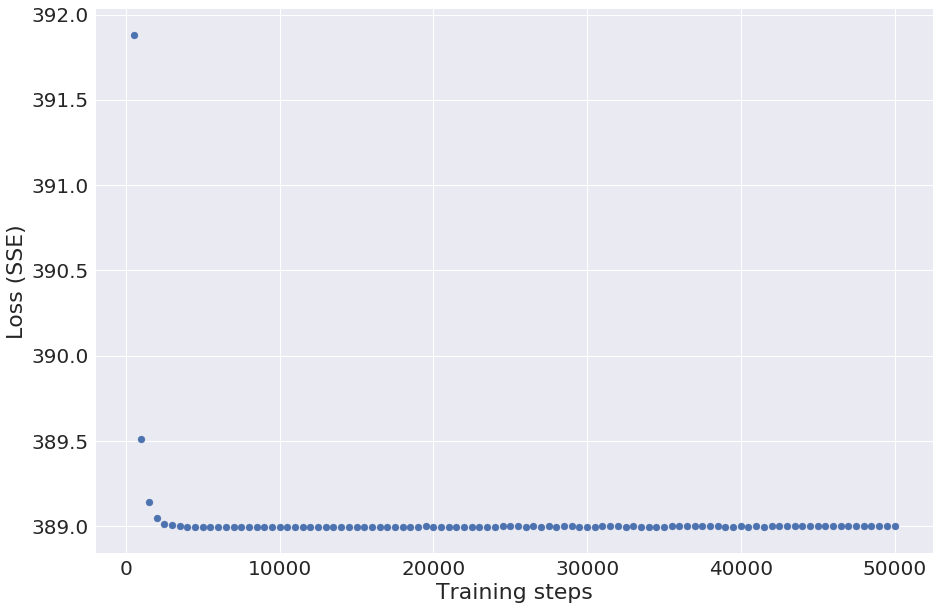

In [91]:
import matplotlib.pyplot as plt  
%matplotlib inline

plt.rcParams['figure.figsize'] = [15, 10]

loss_values = [ev['loss'] for ev in evaluations]  
training_steps = [ev['global_step'] for ev in evaluations]

plt.scatter(x=training_steps, y=loss_values)  
plt.xlabel('Training steps')  
plt.ylabel('Loss (SSE)')  
plt.show()  

In [92]:
predictions = classifier.predict(
    input_fn=lambda:eval_input_fn(X_test,labels=None,
    batch_size=batch_size))

In [93]:
results = list(predictions)

def x(res,j):
    class_id = res[j]['class_ids'][0]
    probability = int(results[j]['probabilities'][class_id] *100)
    return ('%s%% probalitity to be class %d' % (probability,int(class_id)))
    
print ('Predictions for 10 first records on test(dataset):')

for i in range(0,10):    
    print (x(results,i))

INFO:tensorflow:Calling model_fn.
INFO:tensorflow:Done calling model_fn.
INFO:tensorflow:Graph was finalized.
INFO:tensorflow:Restoring parameters from /data/tmp/tf_model_10/model.ckpt-50000
INFO:tensorflow:Running local_init_op.
INFO:tensorflow:Done running local_init_op.
Predictions for 10 first records on test(dataset):
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0
50% probalitity to be class 0


In [94]:
predictions = np.array([p['class_ids'][0] for p in results])

In [95]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [96]:

print("The Explained Variance: %.2f" % explained_variance_score(  
                                            y_test, predictions))  
print("The Mean Absolute Error: %.2f " % mean_absolute_error(  
                                            y_test, predictions))  
print("The Median Absolute Error: %.2f " % median_absolute_error(  
                                            y_test, predictions))

The Explained Variance: 0.00
The Mean Absolute Error: 0.52 
The Median Absolute Error: 0.00 


In [97]:
predictions

array([0, 0, 0, ..., 0, 0, 0])

In [98]:
predictions.size

1386

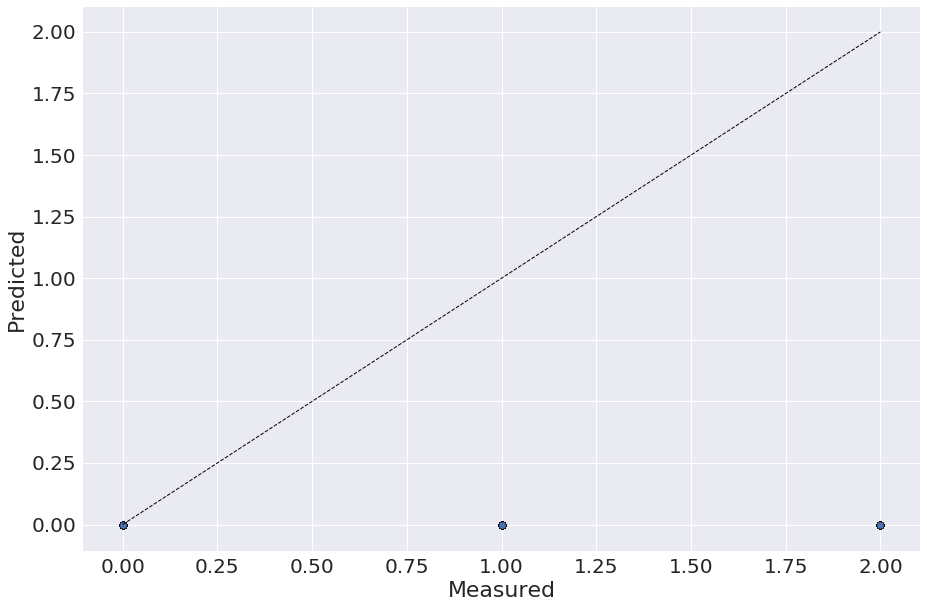

In [99]:
fig, ax = plt.subplots()
ax.scatter(y_test, predictions, edgecolors=(0, 0, 0))
ax.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--', lw=1)
ax.set_xlabel('Measured')
ax.set_ylabel('Predicted')
plt.show()